In [1]:
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
import os
import random
from collections import Counter, defaultdict
from itertools import product, combinations
import math
import cv2
from sklearn.model_selection import train_test_split

random.seed(42)

%matplotlib inline

In [17]:
import keras
from keras.layers import Input, Conv2D, Lambda, average, Dense, Flatten,MaxPooling2D, BatchNormalization, Dropout, Activation, Subtract, subtract
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import numpy.random as rng

In [18]:
IMAGE_SIZE = (70, 70)


def process_image(image_location):
    """
        Given the image location, process the image
    """
    # print(image_location)
    
    image = cv2.imread(image_location)
    
    if image.shape[0] != IMAGE_SIZE[0] or image.shape[1] != IMAGE_SIZE[1]:
        # print("Resizing the image: {0}".format(image_location))
        resized_image = cv2.resize(image, IMAGE_SIZE, interpolation = cv2.INTER_AREA)
    else:
        resized_image = image
    
       
    return resized_image

In [19]:
type_locations = {"b": ["bb", "wb"], "n": ["bn", "wn"], "k": ["bk", "wk"], "p": ["bp", "wp"], "q": ["bq", "wq"], "r": ["br", "wr"]}
type_name_to_label = { "p":0, "b":1, "n":2, "r":3, "q": 4, "k":5 }

## The below cell need to be replaced with the location of the new data

In [20]:
def get_features_labels(data_path):
    X, y = [], []
    features_with_labels = []
    
    for type_name in type_locations:
        for folder_name in type_locations[type_name]:
            piece_type_folder = os.path.join(data_path, folder_name)
            for f in (os.listdir(piece_type_folder)):
                if f.endswith(".jpg"): 
                    

                    img_file_loc = os.path.join(piece_type_folder, f)
                    #print(img_file_loc)
                    grayscale_image = process_image(img_file_loc)
                    actual_image = grayscale_image
                    label = type_name_to_label[type_name]
                    features_with_labels.append({"feature": grayscale_image, "label": label, "image": actual_image})   
                    
    random.shuffle(features_with_labels)
    #print(X[0][0])
    #print(X[0][1])
    X = [x["feature"] for x in features_with_labels]
    y = [x["label"] for x in features_with_labels]
    images = [x["image"] for x in features_with_labels]
    
    X = np.array(X)
    X = X.astype('float32')
    X /= 255

    return X, np.array(y), images

In [21]:
X_train, y_train, _ = get_features_labels("/home/anurag/AR/data/23March/train")
X_test, y_test, test_images = get_features_labels("/home/anurag/AR/data/23March/test")
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5838, 70, 70, 3)
(5838,)
(291, 70, 70, 3)
(291,)


In [22]:
# batch size
batch_size = 64


# number of training epochs
epochs = 150

required_input_shape = (*IMAGE_SIZE, 3)

In [23]:
def load_6_class_cnn_model(model_weights_location):
    """"""
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='valid', input_shape=required_input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.5))

    model.add(Flatten())
    
    model.add(Dense(2048))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.6))
    
    model.add(Dense(6))
    model.add(Activation('softmax'))
    model.summary()
    

    # load the model weights
    model.load_weights(model_weights_location)
                           
    adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return model

In [24]:
trained_model = load_6_class_cnn_model("/home/anurag/AR/trained_models/26Mar/6_class_color_cnn.hdf5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 68, 68, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 68, 68, 32)        128       
_________________________________________________________________
activation_7 (Activation)    (None, 68, 68, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 64)        0         
__________

In [25]:
# Evaluating the model on the test data
score, accuracy = trained_model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

Test score: 3.6834204516459987
Test accuracy: 0.30240549838420044


In [26]:
## Helper method to print a confusion matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    
import matplotlib
matplotlib.rcParams['figure.figsize'] = [100, 15]

IMAGES_PER_ROW = 5

def plot_mispredicted_images(images, actual_values, predicted_values, mapping_func = None):
    print(actual_values)
    mis_predictions = actual_values ^ predicted_values
    mis_prediction_indices = np.nonzero(mis_predictions)[0]
    print(mis_prediction_indices)
    
    num_failed_images = len(mis_prediction_indices)
    
    if num_failed_images == 0:
        print("All images predicted correctly.")
        return
        
    
    if num_failed_images == 1:
        print("{0} mispredicted as {1}".format(actual_values[mis_prediction_indices[0]], predicted_values[mis_prediction_indices[0]]))
        plt.imshow(images[mis_prediction_indices[0]], cmap='gray')
        return
    elif num_failed_images < IMAGES_PER_ROW:
        num_images_per_row = 2
    else:
        num_images_per_row = IMAGES_PER_ROW
        
    num_rows = (num_failed_images // num_images_per_row) + int((num_failed_images % num_images_per_row) != 0)
    if num_rows == 1:
        num_rows = 2

    print("Number of failed images: " + str(num_failed_images))
    print("Num rows: {0}. Num images/row: {1}".format(num_rows, num_images_per_row))
    #print(num_rows)
    #print(num_images_per_row)


    fig, axes = plt.subplots(num_rows, num_images_per_row)

    current_image_idx = 0

    for itr in range(num_rows):
        #print(itr)
        for jtr in range(num_images_per_row):
            if current_image_idx == num_failed_images:
                break
            
            print("{0}, {1}, {2}".format(itr, jtr, current_image_idx))
            axes[itr, jtr].imshow(images[mis_prediction_indices[current_image_idx]], cmap='gray')
            if mapping_func:
                axes[itr, jtr].set_title("{0} predicted as {1}".format(mapping_func(actual_values[mis_prediction_indices[current_image_idx]]), mapping_func(predicted_values[mis_prediction_indices[current_image_idx]])))
            else:
                axes[itr, jtr].set_title("{0} predicted as {1}".format(actual_values[mis_prediction_indices[current_image_idx]], predicted_values[mis_prediction_indices[current_image_idx]]))
            #print(current_image_idx)
            current_image_idx += 1

## Check predictions using the best trained model

In [27]:
# Evaluating the model on the test data
score, accuracy = trained_model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

Test score: 3.6834204516459987
Test accuracy: 0.30240549838420044


Confusion matrix, without normalization
[[31  6  6  2  5  1]
 [26  8  7  9  8  2]
 [27  5  7 10 11  0]
 [17  3  2 21 17  0]
 [10  1  2  2 14  1]
 [ 5  7  0  5  6  7]]
0.3024054982817869


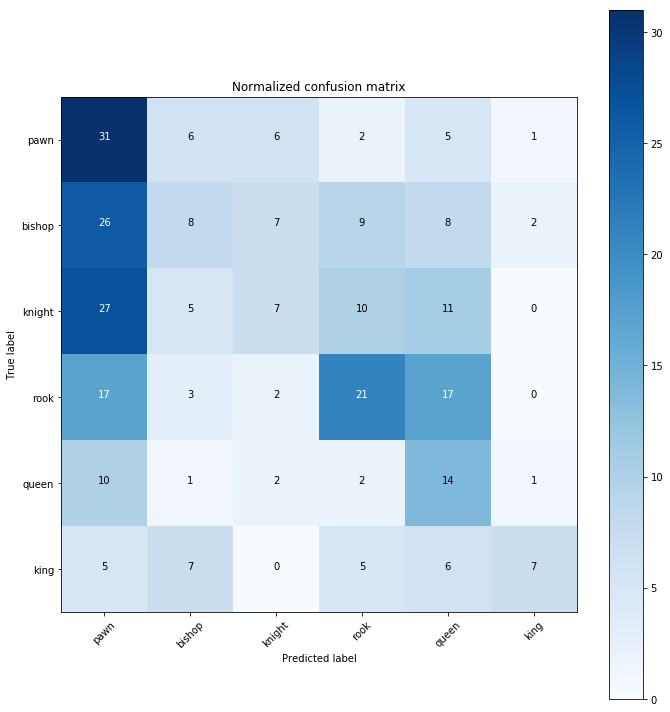

In [28]:
from sklearn.metrics import confusion_matrix, accuracy_score
plt.rcParams["figure.figsize"] = (10,10)
class_names = ["pawn", "bishop", "knight", "rook", "queen", "king"]

#trained_model_path = "/home/anurag/AR/trained_models/23Mar/6_class_cnn_fine_tuned.hdf5"
#trained_model = load_6_class_cnn_model(trained_model_path)

# trained_model.load_weights(filepath)

test_predictions = trained_model.predict(X_test, batch_size=batch_size)
y_test_pred = [np.argmax(x) for x in test_predictions]
cnf_matrix = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,title='Normalized confusion matrix')
print(accuracy_score(y_test, y_test_pred))

In [29]:
base_location = "/home/anurag/AR/analysis_results/30Mar"
def save_mispredicted_images(images, actual_values, predicted_values, mapping_func = None):
    # print(actual_values)
    mis_predictions = actual_values ^ predicted_values
    mis_prediction_indices = np.nonzero(mis_predictions)[0]
    print(mis_prediction_indices)
    
    num_failed_images = len(mis_prediction_indices)
    
    if num_failed_images == 0:
        print("All images predicted correctly.")
        return
        
    
    if num_failed_images == 1:
        print("{0} mispredicted as {1}".format(actual_values[mis_prediction_indices[0]], predicted_values[mis_prediction_indices[0]]))
        plt.imshow(images[mis_prediction_indices[0]], cmap='gray')
        return
    elif num_failed_images < IMAGES_PER_ROW:
        num_images_per_row = 2
    else:
        num_images_per_row = IMAGES_PER_ROW
        
    num_rows = (num_failed_images // num_images_per_row) + int((num_failed_images % num_images_per_row) != 0)
    if num_rows == 1:
        num_rows = 2

    print("Number of failed images: " + str(num_failed_images))
    print("Num rows: {0}. Num images/row: {1}".format(num_rows, num_images_per_row))
    #print(num_rows)
    #print(num_images_per_row)


    # fig, axes = plt.subplots(num_rows, num_images_per_row)

    current_image_idx = 0

    for itr in range(num_rows):
        #print(itr)
        for jtr in range(num_images_per_row):
            if current_image_idx == num_failed_images:
                break
            
            # print("{0}, {1}, {2}".format(itr, jtr, current_image_idx))
            
            # axes[itr, jtr].imshow(images[mis_prediction_indices[current_image_idx]], cmap='gray')
            if mapping_func:
                image_location = os.path.join(base_location, str(current_image_idx) + "_" + "{0}_as_{1}.jpg".format(mapping_func(actual_values[mis_prediction_indices[current_image_idx]]), mapping_func(predicted_values[mis_prediction_indices[current_image_idx]])))
                cv2.imwrite(image_location, images[mis_prediction_indices[current_image_idx]])
    
            else:
                image_location = os.path.join(base_location, str(current_image_idx) + "_" + "{0}_as_{1}.jpg".format(actual_values[mis_prediction_indices[current_image_idx]], predicted_values[mis_prediction_indices[current_image_idx]]))
                cv2.imwrite(image_location, images[mis_prediction_indices[current_image_idx]])
            #print(current_image_idx)
            current_image_idx += 1    

In [30]:
# test_images = np.squeeze(X_test)
reverse_label_mappings = {type_name_to_label[y]: y for y in type_name_to_label}
print(reverse_label_mappings)
save_mispredicted_images(test_images, y_test, y_test_pred, lambda x: reverse_label_mappings[x])
# plot_mispredicted_images(test_images, y_test, y_test_pred, lambda x: reverse_label_mappings[x])

{0: 'p', 1: 'b', 2: 'n', 3: 'r', 4: 'q', 5: 'k'}
[  1   3   6   7   8  11  12  13  14  15  16  18  19  20  21  22  24  25
  27  28  30  31  32  33  34  35  36  37  38  39  40  42  43  45  46  47
  48  49  50  52  54  57  60  63  64  65  66  71  72  73  74  77  79  80
  82  85  86  87  88  89  91  92  93  94  95  97  98  99 100 101 103 104
 105 106 107 108 112 113 115 116 117 118 119 121 123 124 125 127 128 129
 130 131 132 133 134 135 136 138 141 143 144 146 147 148 149 150 151 152
 154 155 156 158 159 160 162 165 167 168 169 170 171 174 175 176 177 178
 180 182 183 184 185 186 187 188 189 190 192 193 194 195 197 200 201 202
 204 205 206 208 209 212 213 214 215 216 218 219 220 222 223 224 227 229
 230 231 232 234 235 239 240 241 242 244 245 246 247 249 251 252 253 255
 256 257 259 260 262 263 264 266 270 273 274 275 276 279 280 281 282 283
 284 285 286 289 290]
Number of failed images: 203
Num rows: 41. Num images/row: 5
